<a href="https://colab.research.google.com/github/nicoRomeroCuruchet/DynamicProgramming/blob/main/testing_bary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pickle
import numpy as np
import gymnasium as gym
from utils.utils import test_enviroment
from PolicyIteration import PolicyIteration

2025-02-10 20:23:30.288 | WARNING  | PolicyIteration:<module>:18 - CUDA is not available. Falling back to NumPy.


In [2]:
import airplane

glider = gym.make('ReducedSymmetricGliderPullout-v0')

bins_space = {
    "flight_path_angle": np.linspace(-np.pi, 0.5,    100,      dtype=np.float32),     # Flight Path Angle (γ)    (0)
    "airspeed_norm":     np.linspace(0.7, 4.0,       100,      dtype=np.float32),     # Air Speed         (V)    (1)
}

pi = PolicyIteration(
    env=glider, 
    bins_space=bins_space,
    action_space=np.linspace(-0.4, 1.0, 15, dtype=np.float32),
    gamma=0.99,
    theta=1e-3,
)


pi.run()

2025-02-10 20:23:33.514 | INFO     | PolicyIteration:__init__:129 - Lower bounds: [-3.1415927  0.7      ]
2025-02-10 20:23:33.514 | INFO     | PolicyIteration:__init__:130 - Upper bounds: [0.5 4. ]
2025-02-10 20:23:33.514 | INFO     | PolicyIteration:__init__:148 - The action space is: [-4.000000e-01 -3.000000e-01 -2.000000e-01 -1.000000e-01 -5.551115e-17
  1.000000e-01  2.000000e-01  3.000000e-01  4.000000e-01  5.000000e-01
  6.000000e-01  7.000000e-01  8.000000e-01  9.000000e-01  1.000000e+00]
2025-02-10 20:23:33.514 | INFO     | PolicyIteration:__init__:149 - Number of states: 10000
2025-02-10 20:23:33.514 | INFO     | PolicyIteration:__init__:150 - Total states:150000
2025-02-10 20:23:33.518 | INFO     | PolicyIteration:__init__:163 - Policy Iteration was correctly initialized.
2025-02-10 20:23:33.518 | INFO     | PolicyIteration:__init__:164 - The enviroment name is: TimeLimit
2025-02-10 20:23:33.518 | INFO     | PolicyIteration:run:387 - Creating Delaunay triangulation over the s

In [ ]:
STALL_AIRSPEED = 27.331231856346
from utils.utils import get_optimal_action

for action in np.linspace(-0.4, 1.0, 15, dtype=np.float32):

    state = np.array([0.05, 1.83])
    glider.airplane.flight_path_angle = state[0]
    glider.airplane.airspeed_norm = state[1]
    
    total_reward = 0
    episode_length = 0

    while episode_length <100:
        #action = get_optimal_action(state, pi)
        prev_state  = state.copy()
        state, reward, _, _, _ = glider.step(action)
        state = state[0]
        total_reward += reward*STALL_AIRSPEED
        episode_length += 1
    
    print(f"Action: {action} Reward: {total_reward} Episode Length: {episode_length}")
        

In [3]:
STALL_AIRSPEED = 27.331231856346
from utils.utils import get_optimal_action
from tqdm import tqdm
with open(glider.__class__.__name__ + ".pkl", "rb") as f:
    pi: PolicyIteration = pickle.load(f)

prom_episode_lenght = 0
dict_result = {}
dict_episode_length = {}
state_spaces = [v for v in pi.states_space if v[0] > -np.pi/2]
for state in tqdm(state_spaces):
    initial_state = state.copy()
    prev_state = state.copy()
    glider.reset()
    glider.airplane.flight_path_angle = state[0]
    glider.airplane.airspeed_norm = state[1]
    done = False
    episode_length = 0
    total_reward = 0
    while not done:
        action = get_optimal_action(state, pi)
        prev_state  = state.copy()
        state, reward, done, _, _ = glider.step(action)
        done  = bool(done)
        if done:
            break
        state = state[0]
        # check if our state is in the state space
        index = pi.triangulation.find_simplex(state)
        if not done:
            total_reward -= reward#*STALL_AIRSPEED
        if (index ==-1) or episode_length > 70: 
            done = True
        episode_length += 1
        
    dict_result[tuple(initial_state)] = total_reward
    dict_episode_length[tuple(initial_state)] = episode_length
    prom_episode_lenght += episode_length / len(pi.states_space)
    #print(f"Initial state: {initial_state} - Total reward: {total_reward}")

100%|██████████| 5700/5700 [00:46<00:00, 122.47it/s]


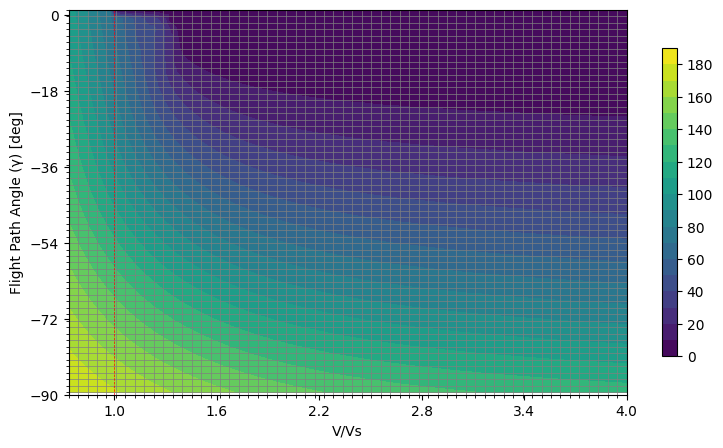

In [4]:
import numpy as np
import matplotlib.pyplot as plt
epsilon = 1*1e-1
#dict_result = dict_episode_length
# Your dictionary with keys as coordinates (x, y) and values as the color intensity (z)
# Extracting the x, y and z values
x = [np.degrees(coord[0]) for coord in dict_result.keys() if 0.05 >= coord[0] >= -np.pi/2 - epsilon and coord[1] > 0.7]
#convert x to grad
y = [coord[1] for coord in dict_result.keys() if 0.05 >= coord[0] >= -np.pi/2 - epsilon and coord[1] > 0.7]
#convert y to Vs
keys_list = list(dict_result.keys())
values_list = list(dict_result.values())
z = [v for e,v in zip(keys_list, values_list) if 0.05 >= e[0] >= -np.pi/2 - epsilon and e[1] > 0.7]

# Creating a 2D scatter plot
cmap = plt.get_cmap('viridis', 2048)
plt.tricontourf(y, x, z, cmap=cmap, levels=18)   # Change 'viridis' to any other colormap you like
plt.colorbar(label='', shrink=0.8,  )  # Add color bar for the z values

# Add labels and a title
plt.ylabel('Flight Path Angle (γ) [deg]')
plt.xlabel('V/Vs')

x_min, x_max = min(x), max(x)
y_min, y_max = min(y), max(y)

# Set the minor ticks for the grid, keeping the dense grid with smaller squares
ax = plt.gca()  # Get current axes
ax.set_yticks(np.linspace(x_min, x_max, 60), minor=True)  # 20 minor ticks for grid
ax.set_xticks(np.linspace(y_min, y_max, 60), minor=True)  # 20 minor ticks for grid
# put line x = 1
plt.axvline(x=1, color='r', linestyle='--', linewidth=0.5)
# put line y = 0
#plt.axhline(y=0, color='k', linestyle='--')

# Show the plot
vals = np.round(np.linspace(-90, 0,6))
plt.yticks(vals)  # Only 5 labels on x-axis
plt.xticks(np.linspace(round(y_min), round(y_max), 6))  # Only 5 labels on y-axis
# Enable the minor grid lines
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)

# Habilitar la cuadrícula en las marcas menores
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)

# Guardar la imagen sin borde blanco
plt.savefig('output.png', bbox_inches='tight')

# set size of the plot
plt.gcf().set_size_inches(9, 5)

plt.show()


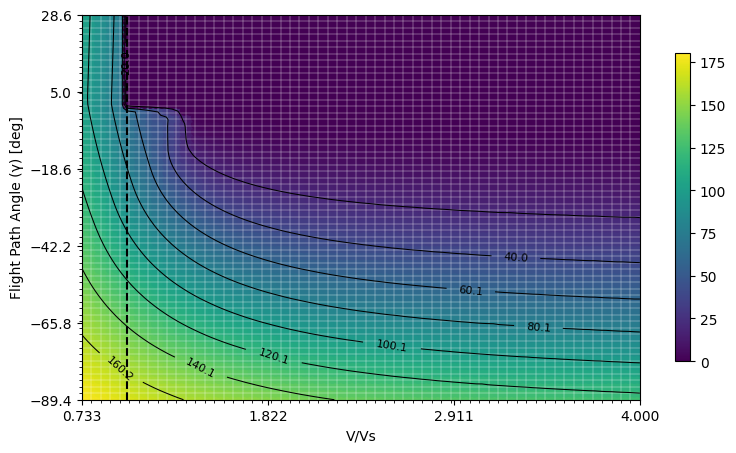

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Your dictionary with keys as coordinates (x, y) and values as the color intensity (z)
# Extracting the x, y and z values
x = [np.degrees(coord[0]) for coord in dict_result.keys() if 5 >= coord[0] >= -np.pi/2 and coord[1] > 0.7]
y = [coord[1] for coord in dict_result.keys() if 5 >= coord[0] >= -np.pi/2 and coord[1] > 0.7]
keys_list = list(dict_result.keys())
values_list = list(dict_result.values())
z = [v for e,v in zip(keys_list, values_list) if 5 >= e[0] >= -np.pi/2 and e[1] > 0.7]

# Create a grid for interpolation
x_grid = np.linspace(min(x), max(x), 100)
y_grid = np.linspace(min(y), max(y), 100)
X, Y = np.meshgrid(x_grid, y_grid)

# Interpolate the scattered data into the grid
Z = griddata((y, x), z, (Y, X), method='linear')

# Create the scatter plot
cmap = plt.get_cmap('viridis', 2048)
plt.scatter(y, x, c=z, cmap=cmap)

# Add color bar
plt.colorbar(label='', shrink=0.8)
contour_levels = np.linspace(np.min(z), np.max(z), 10)  # 10 levels
contour_levels = contour_levels[contour_levels != 0]    # Remove zero from levels

# Add contour lines on top of the scatter plot
contour = plt.contour(Y, X, Z, levels=contour_levels, colors='black', linewidths=0.75)
plt.clabel(contour, inline=True, fontsize=8)  # Optional: add labels to the contours

# Add labels and a title
plt.ylabel('Flight Path Angle (γ) [deg]')
plt.xlabel('V/Vs')

# Plot vertical line at x=1
plt.axvline(x=1, color='k', linestyle='--')

# Configure the minor ticks and grid
x_min, x_max = min(x), max(x)
y_min, y_max = min(y), max(y)
ax = plt.gca()  # Get current axes
ax.set_yticks(np.linspace(x_min, x_max, 60), minor=True)
ax.set_xticks(np.linspace(y_min, y_max, 60), minor=True)
plt.yticks(np.linspace(x_min, x_max, 6))  # Major ticks on y-axis
plt.xticks(np.linspace(y_min, y_max, 4))  # Major ticks on x-axis

# Set size of the plot
plt.gcf().set_size_inches(9, 5)

# Enable the minor grid lines
ax.grid(which='minor', color='white', linestyle='-', linewidth=0.25)

# Habilitar la cuadrícula en las marcas menores
ax.grid(which='minor', color='white', linestyle='-', linewidth=0.25)

# Save the image
plt.savefig('output_with_contours.png', bbox_inches='tight')

# Show the plot
plt.show()


# CartPoleEnv 

### Observation Space

The observation is a `ndarray` with shape `(4,)` with the values corresponding to the following positions and velocities:

| Num | Observation           | Min                 | Max               |
|-----|-----------------------|---------------------|-------------------|
| 0   | Cart Position         | -4.8                | 4.8               |
| 1   | Cart Velocity         | -Inf                | Inf               |
| 2   | Pole Angle            | ~ -0.418 rad (-24°) | ~ 0.418 rad (24°) |
| 3   | Pole Angular Velocity | -Inf                | Inf               |

### Action Space

The action is a `ndarray` with shape `(1,)` which can take values `{0, 1}` indicating the direction
of the fixed force the cart is pushed with.

- 0: Push cart to the left
- 1: Push cart to the right

In [ ]:
# Train cartpole environment:
from classic_control.cartpole import CartPoleEnv
# CartPole environment:
env = CartPoleEnv(sutton_barto_reward=True)
# position thresholds:
x_lim         = 2.4
theta_lim     = 0.418 
# velocity thresholds:
x_dot_lim     = 3.1
theta_dot_lim = 3.1

bins_space = {
    "x_space"         : np.linspace(-x_lim, x_lim, 10,  dtype=np.float32),                     # position space          (0)
    "x_dot_space"     : np.linspace(-x_dot_lim, x_dot_lim, 10,  dtype=np.float32),             # velocity space          (1)
    "theta_space"     : np.linspace(-theta_lim, theta_lim, 10, dtype=np.float32),              # angle space             (2)
    "theta_dot_space" : np.linspace(-theta_dot_lim, theta_dot_lim, 10, dtype=np.float32),      # angular velocity space  (3)
}

pi = PolicyIteration(
    env=env, 
    bins_space=bins_space,
    action_space=np.array([0, 1], dtype=np.int32),
    gamma=0.99,
    theta=1e-3
)

pi.run()

In [ ]:
# Test cartpole environment:

with open(env.__class__.__name__ + ".pkl", "rb") as f:
    pi = pickle.load(f)

test_enviroment(CartPoleEnv(sutton_barto_reward=True, render_mode="human"), pi)

## Observation Space

The observation is a `ndarray` with shape `(2,)` where the elements correspond to the following:

| Num | Observation                          | Min   | Max  | Unit         |
|-----|--------------------------------------|-------|------|--------------|
| 0   | position of the car along the x-axis | -1.2  | 0.6  | position (m) |
| 1   | velocity of the car                  | -0.07 | 0.07 | velocity (v) |

## Action Space

There are 3 discrete deterministic actions:

- 0: Accelerate to the left
- 1: Don't accelerate
- 2: Accelerate to the right


In [ ]:
from classic_control.continuous_mountain_car import Continuous_MountainCarEnv

env=Continuous_MountainCarEnv()

bins_space = {
    "x_space":     np.linspace(env.min_position, env.max_position, 100,      dtype=np.float32),    # position space    (0)
    "x_dot_space": np.linspace(-abs(env.max_speed), abs(env.max_speed), 100, dtype=np.float32),    # velocity space    (1)
}

pi = PolicyIteration(
    env=env, 
    bins_space=bins_space,
    action_space=np.linspace(-1.0, +1.0, 9, dtype=np.float32),
    gamma=0.99,
    theta=1e-3,
)
pi.run()

In [ ]:
# Test mountain car environment:
with open(env.__class__.__name__ + ".pkl", "rb") as f:
    pi: PolicyIteration = pickle.load(f)

test_enviroment(Continuous_MountainCarEnv(render_mode="human"), pi)